In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import random as rnd
import math
import glob
from copy import copy
from scipy.spatial import distance
from sklearn.metrics import calinski_harabaz_score, silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from scipy.spatial import distance
from IPython.core.debugger import set_trace

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from tqdm import tqdm_notebook
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt

from utils import project, cross_val_score_custom, MF2PCA2ORIG, create_clustering_pivot_table, clustering, plot_proj_clustering

In [2]:
# paths to the databases containing the PCA and Isomap projections 
root_pca = './separate_datasets_data'
root_mf = './separate_datasets_transformed_data/'

paths = [os.path.join(root_pca,path) for path in os.listdir(root_pca)]
paths_mf = [os.path.join(root_mf,path) for path in os.listdir(root_mf)]

paths_pca = list(filter(lambda x: 'err' not in x.split("/")[-1].split(".")[0].split('_'), paths))

paths_mf_lle = list(filter(lambda x: 'lle' in x.split("/")[-1].split(".")[0].split('_'), paths_mf))
paths_mf_isomap = list(filter(lambda x: 'isomap' in x.split("/")[-1].split(".")[0].split('_'), paths_mf))

In [3]:
label2path = {}
for path in paths_pca + paths_mf_lle + paths_mf_isomap:
    label = path.split("/")[-1].split(".")[0]
    label_split = label.split('_')[:4]
    label = '_'.join(label_split)
    label2path[label] = path

In [4]:
label2path

{'ptb_proj_f': './separate_datasets_data/ptb_proj_f.csv',
 'AGP_proj_o': './separate_datasets_data/AGP_proj_o.csv',
 't2d_proj_f': './separate_datasets_data/t2d_proj_f.csv',
 'ibd_proj_o': './separate_datasets_data/ibd_proj_o.csv',
 't2d_proj_g': './separate_datasets_data/t2d_proj_g.csv',
 'ptb_proj_g': './separate_datasets_data/ptb_proj_g.csv',
 'ptb_proj_o': './separate_datasets_data/ptb_proj_o.csv',
 'AGP_proj_f': './separate_datasets_data/AGP_proj_f.csv',
 'AGP_proj_g': './separate_datasets_data/AGP_proj_g.csv',
 'ibd_proj_f': './separate_datasets_data/ibd_proj_f.csv',
 't2d_proj_o': './separate_datasets_data/t2d_proj_o.csv',
 'ibd_proj_g': './separate_datasets_data/ibd_proj_g.csv',
 't2d_proj_o_lle': './separate_datasets_transformed_data/t2d_proj_o_lle.csv',
 'AGP_proj_f_lle': './separate_datasets_transformed_data/AGP_proj_f_lle.csv',
 'ibd_proj_g_lle': './separate_datasets_transformed_data/ibd_proj_g_lle.csv',
 'ibd_proj_f_lle': './separate_datasets_transformed_data/ibd_proj_f_ll

# Distances, PCA

In [5]:
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,7))
# for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
#     for j,tax_name in enumerate(['o', 'f', 'g']):
#         label = '_'.join([dataset_name, 'proj', tax_name])
#         p = label2path[label]
#         data = np.genfromtxt(p, delimiter=';')
#         pdists = pairwise_distances(data).flatten()
#         axes[i,j].hist(pdists, bins=50)
#         axes[i,j].set_title(label)
#         axes[i,j].set_yscale('log')

# plt.tight_layout()
# plt.show()

# Distances LLE

In [6]:
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,7))
# for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
#     for j,tax_name in enumerate(['o', 'f', 'g']):
#         label = '_'.join([dataset_name, 'proj', tax_name, 'lle'])
#         p = label2path[label]
#         data = np.genfromtxt(p, delimiter=';')
#         pdists = pairwise_distances(data).flatten()
#         axes[i,j].hist(pdists, bins=50)
#         axes[i,j].set_title(label)
#         axes[i,j].set_yscale('log')
        
# plt.tight_layout()
# plt.show()

# Distances Isomap

In [7]:
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,7))
# for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
#     for j,tax_name in enumerate(['o', 'f', 'g']):
#         label = '_'.join([dataset_name, 'proj', tax_name, 'isomap'])
#         p = label2path[label]
#         data = np.genfromtxt(p, delimiter=';')
#         pdists = pairwise_distances(data).flatten()
#         axes[i,j].hist(pdists, bins=50)
#         axes[i,j].set_title(label)
#         axes[i,j].set_yscale('log')
        
# plt.tight_layout()
# plt.show()

# Reconstruction

In [8]:
res_mf2pca_mae = defaultdict(list)
max_dims = {}
res_inv_pca_mae = {}
res_mf2pca2orig_mae = defaultdict(list)

def mae_score(y, y_pred):
    return np.linalg.norm(y_pred - y, axis=1, ord=1).mean() / np.linalg.norm(y, axis=1, ord=1).mean()

scorer_mae = make_scorer(mae_score, greater_is_better=False)

PARAMS_GRIDSEARCH_DICT = {'estimator__n_neighbors' : [4, 6, 8, 10, 12],
                         'estimator__weights' : ['uniform', 'distance'],
                         'estimator__leaf_size' : [20, 40, 60, 100],
                         'estimator__p' : [2, 3, 1]}

In [ ]:
f = 'AGP'
t = 'g'
label = f'{f}_proj_{t}'
dataframe = pd.read_csv(f'{f}/pivot_{t}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
dataframe = dataframe.drop('Unnamed: 0', axis = 1)
data = dataframe.values
data_projected, pca = project(data, plot=False)
data_projected_inverse = pca.inverse_transform(data_projected)

MAX_DIM = data_projected.shape[1]
print('MAX_DIM', MAX_DIM)

max_dims[label] = MAX_DIM
res_inv_pca_mae[label] = mae_score(data_projected_inverse, data)

dims = np.arange(2,MAX_DIM, 4)

for n in tqdm_notebook(dims):
    transformer = Isomap(n_components=n, n_neighbors=12)
    dataset_transformed = transformer.fit_transform(data_projected)

    gridsearch = GridSearchCV(mo_knn, PARAMS_GRIDSEARCH_DICT, scoring=scorer_mae, cv=5, refit=False, n_jobs=-1)
    best_params = gridsearch.fit(dataset_transformed, data_projected).best_params_
    mo_knn_best = mo_knn.set_params(**best_params)
    est_composed = MF2PCA2ORIG(pca, mo_knn_best)

    cv_results_mae_mf2pca = cross_val_score(mo_knn_best, dataset_transformed, data_projected, scoring=scorer_mae, cv=5, n_jobs=-1)
    cv_results_mae_mf2orig = cross_val_score_custom(est_composed, dataset_transformed, data_projected, data, mae_score, cv=5)

    res_mf2pca_mae[label].append(cv_results_mae_mf2pca.mean())
    res_mf2pca2orig_mae[label].append(cv_results_mae_mf2orig.mean()) 

MAX_DIM 52


# PCA clustering

In [17]:
methods_dict_PCA = {'dbscan':[DBSCAN, np.linspace(0.0001, 0.7, 25)],
                   'KMeans':[KMeans, np.arange(2, 15, 1)],
                   'SpectralClustering':[SpectralClustering, np.arange(2, 15, 1)]} 
                    


dbscan_results = clustering(paths_pca, *methods_dict_PCA['dbscan'])

kmeans_results = clustering(paths_pca, *methods_dict_PCA['KMeans'])

spectral_results = clustering(paths_pca, *methods_dict_PCA['SpectralClustering'])

Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.0001
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.40837499999999993
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.43753749999999997
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.46669999999999995
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.49586249999999993
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.525025
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.5541874999999999
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.5833499999999999
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.6125124999999999
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.6416749999999999
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.6708375
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.7
Only one cluster was found for AGP

Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.37921249999999995
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.40837499999999993
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.43753749999999997
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.46669999999999995
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.49586249999999993
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.525025
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.5541874999999999
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.5833499999999999
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.6125124999999999
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.6416749999999999
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.6708375
Only one cluster was found for ptb_proj_o, method: DBSCAN param: 0.7
Only one cluster was 

# DBSCAN: PCA

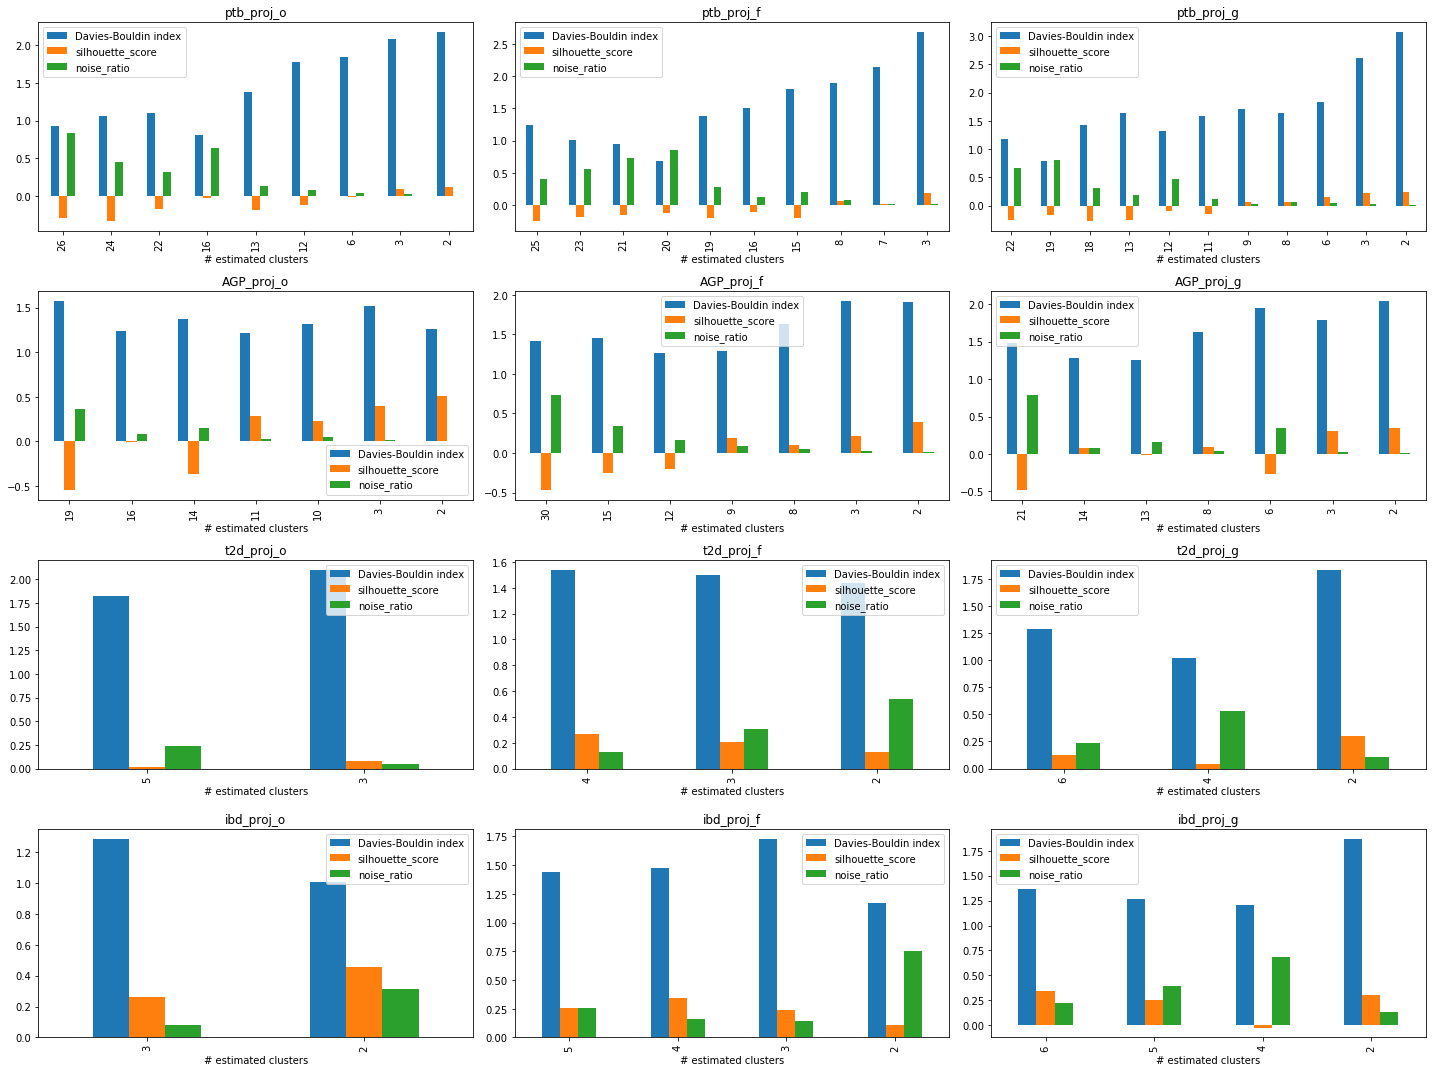

In [40]:
plot_proj_clustering(dbscan_results)

# KMEANS: PCA

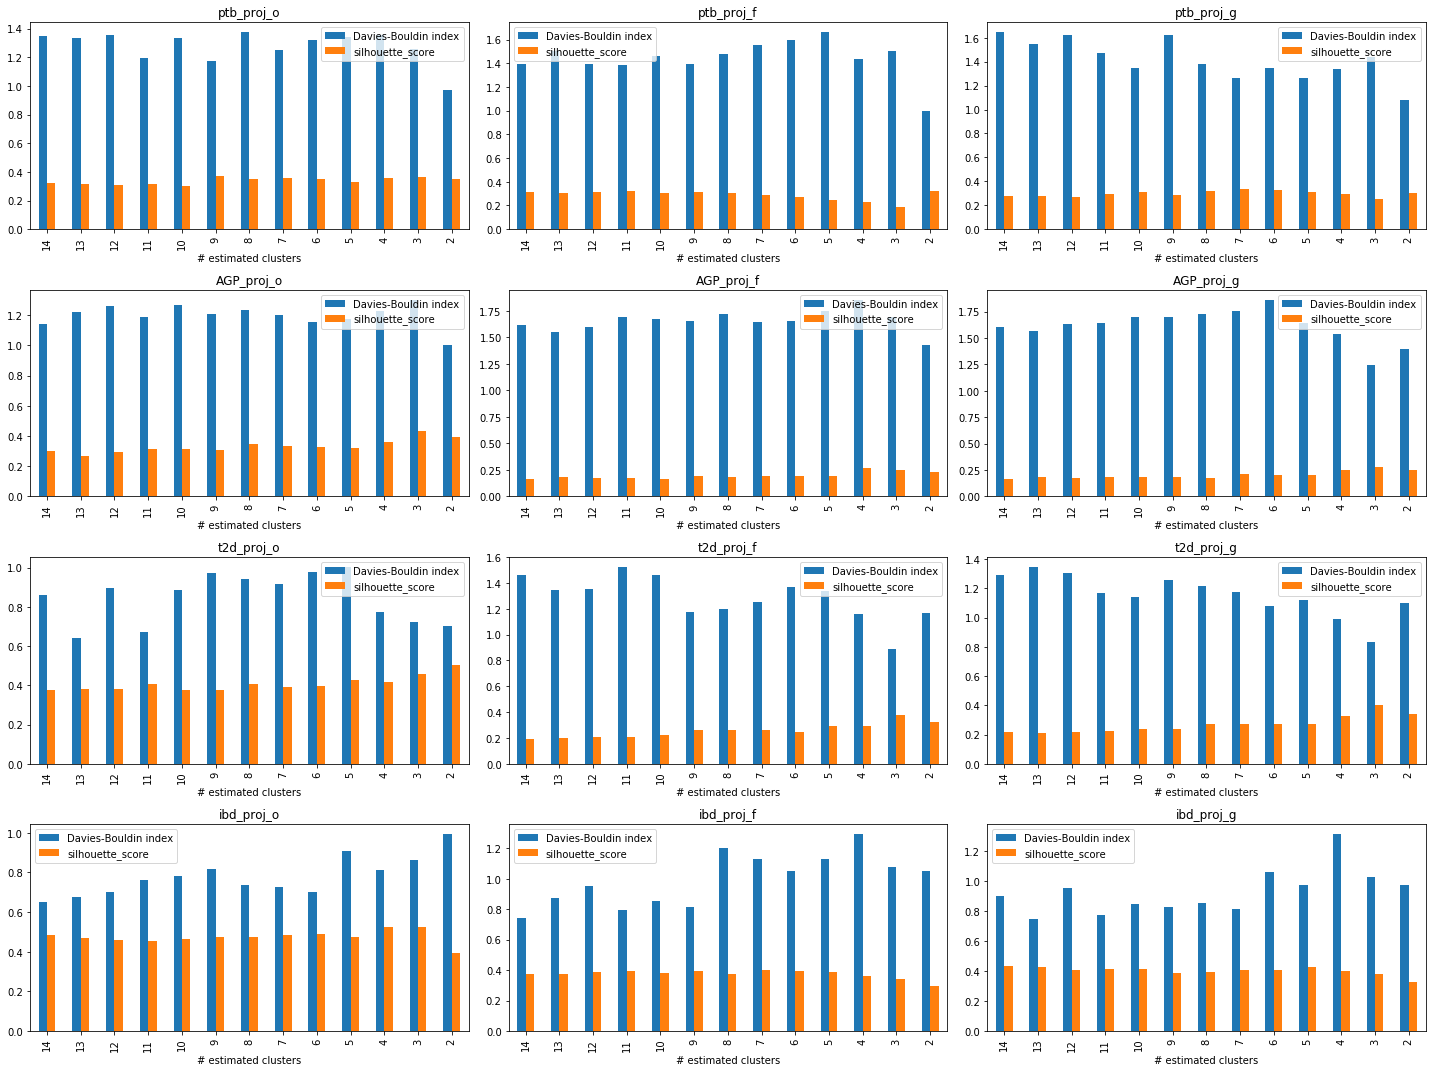

In [19]:
plot_proj_clustering(kmeans_results)

# SPECTRAL: PCA

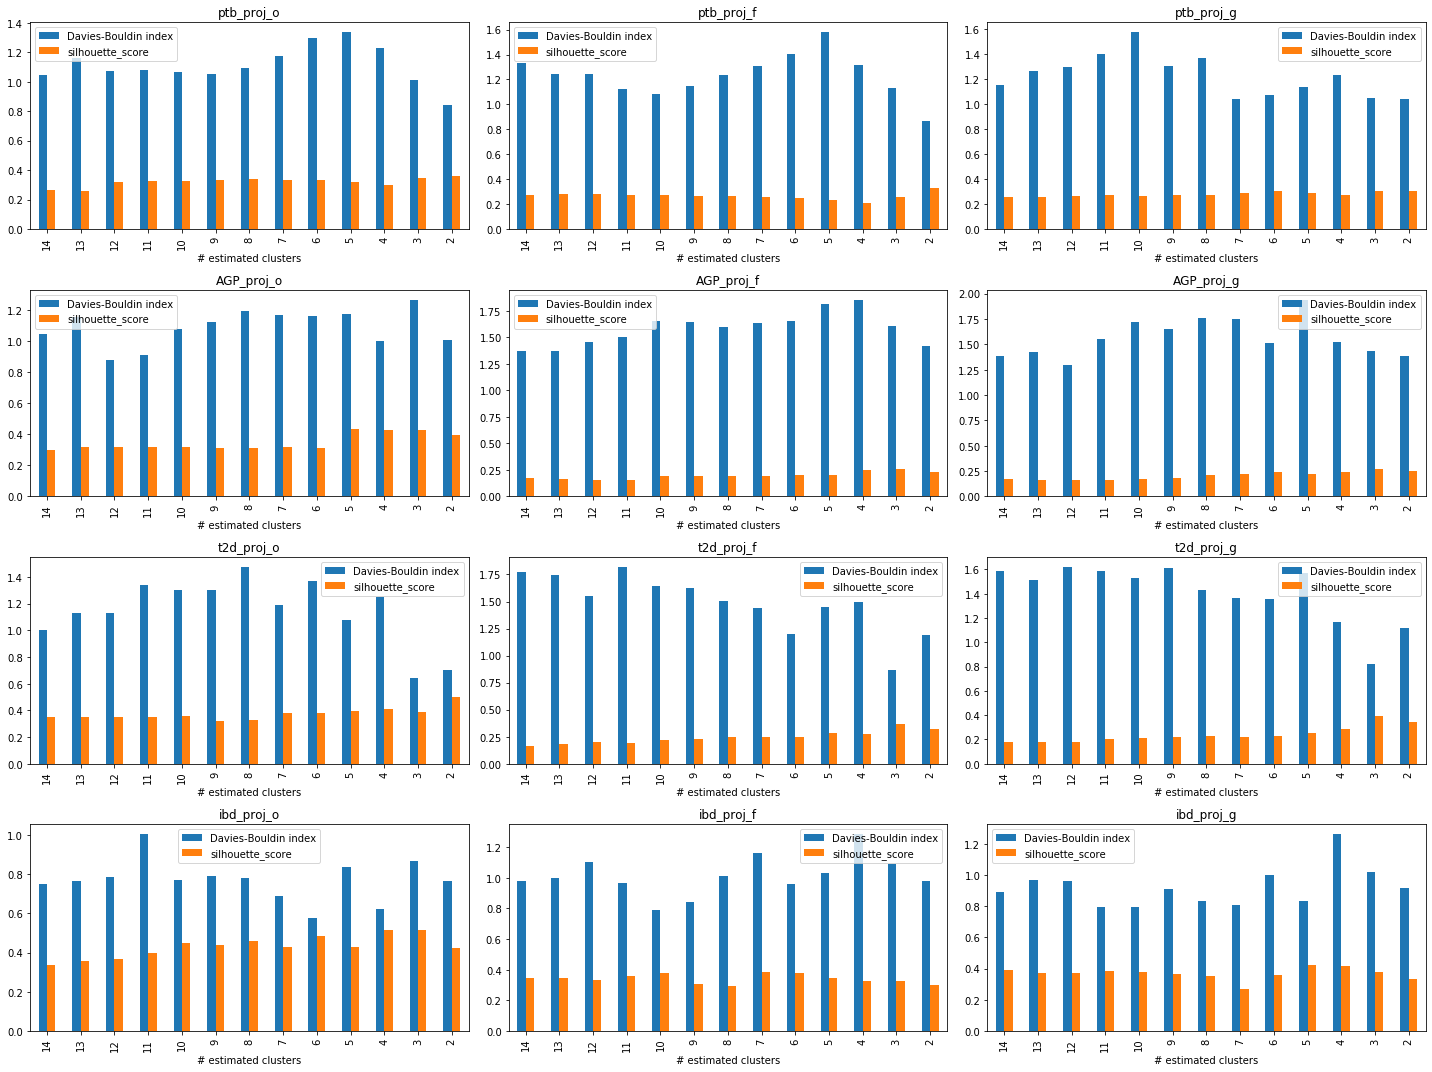

In [20]:
plot_proj_clustering(spectral_results)


# Aggregation

In [84]:
methods_names = list(methods_dict_PCA.keys())
datasets_names = sorted(list(dbscan_results.keys()))

X_dbind, X_silh = create_clustering_pivot_table([dbscan_results, kmeans_results, spectral_results], methods_names, datasets_names)

In [85]:
X_silh

AGP_proj_f  AGP_proj_g  AGP_proj_o  ibd_proj_f  \
dbscan                     2.0         2.0         2.0         4.0   
KMeans                     4.0         3.0         3.0         7.0   
SpectralClustering         3.0         3.0         5.0         7.0   

                    ibd_proj_g  ibd_proj_o  ptb_proj_f  ptb_proj_g  \
dbscan                     6.0         3.0         3.0         2.0   
KMeans                    14.0         4.0        11.0         7.0   
SpectralClustering         5.0         3.0         2.0         3.0   

                    ptb_proj_o  t2d_proj_f  t2d_proj_g  t2d_proj_o  
dbscan                     2.0         4.0         2.0         3.0  
KMeans                     9.0         3.0         3.0         2.0  
SpectralClustering         2.0         3.0         3.0         2.0

# For ISOMAP

In [25]:
methods_dict_ISOMAP = {'dbscan':[DBSCAN, np.linspace(0.0001, 1., 25)],
                       'KMeans':[KMeans, np.arange(2, 15, 1)],
                      'SpectralClustering':[SpectralClustering, np.arange(2, 15, 1)]} 

methods_names = list(methods_dict_ISOMAP.keys())

isomap_cluster_results_list = []
for method_name in methods_names:
    method_class, param_range = methods_dict_ISOMAP[method_name]
    cluster_results = clustering(paths_mf_isomap, method_class, param_range)
    isomap_cluster_results_list.append(cluster_results)

Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.0001
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.250075
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.2917375
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.3334
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.37506249999999997
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.41672499999999996
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.45838749999999995
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.50005
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.5417124999999999
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.583375
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.6250374999999999
Only one cluster was found for AGP_proj_o_isomap, method: DB

Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.6250374999999999
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.6667
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.7083625
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.7500249999999999
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.7916875
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.8333499999999999
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.8750125
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.9166749999999999
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 0.9583375
Only one cluster was found for AGP_proj_f_isomap, method: DBSCAN param: 1.0
Only one cluster was found for ibd_proj_f_isomap, method: DBSCAN param: 0.0001
Only one cluster was found for ibd_proj_f_isomap, method: DBSCAN param: 0.

Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.6250374999999999
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.6667
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.7083625
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.7500249999999999
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.7916875
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.8333499999999999
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.8750125
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.9166749999999999
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 0.9583375
Only one cluster was found for t2d_proj_g_isomap, method: DBSCAN param: 1.0
Only one cluster was found for ptb_proj_f_isomap, method: DBSCAN param: 0.41672499999999996
Only one cluster was found for ptb_proj_f_isomap, method: DBS

# DBSCAN: ISOMAP

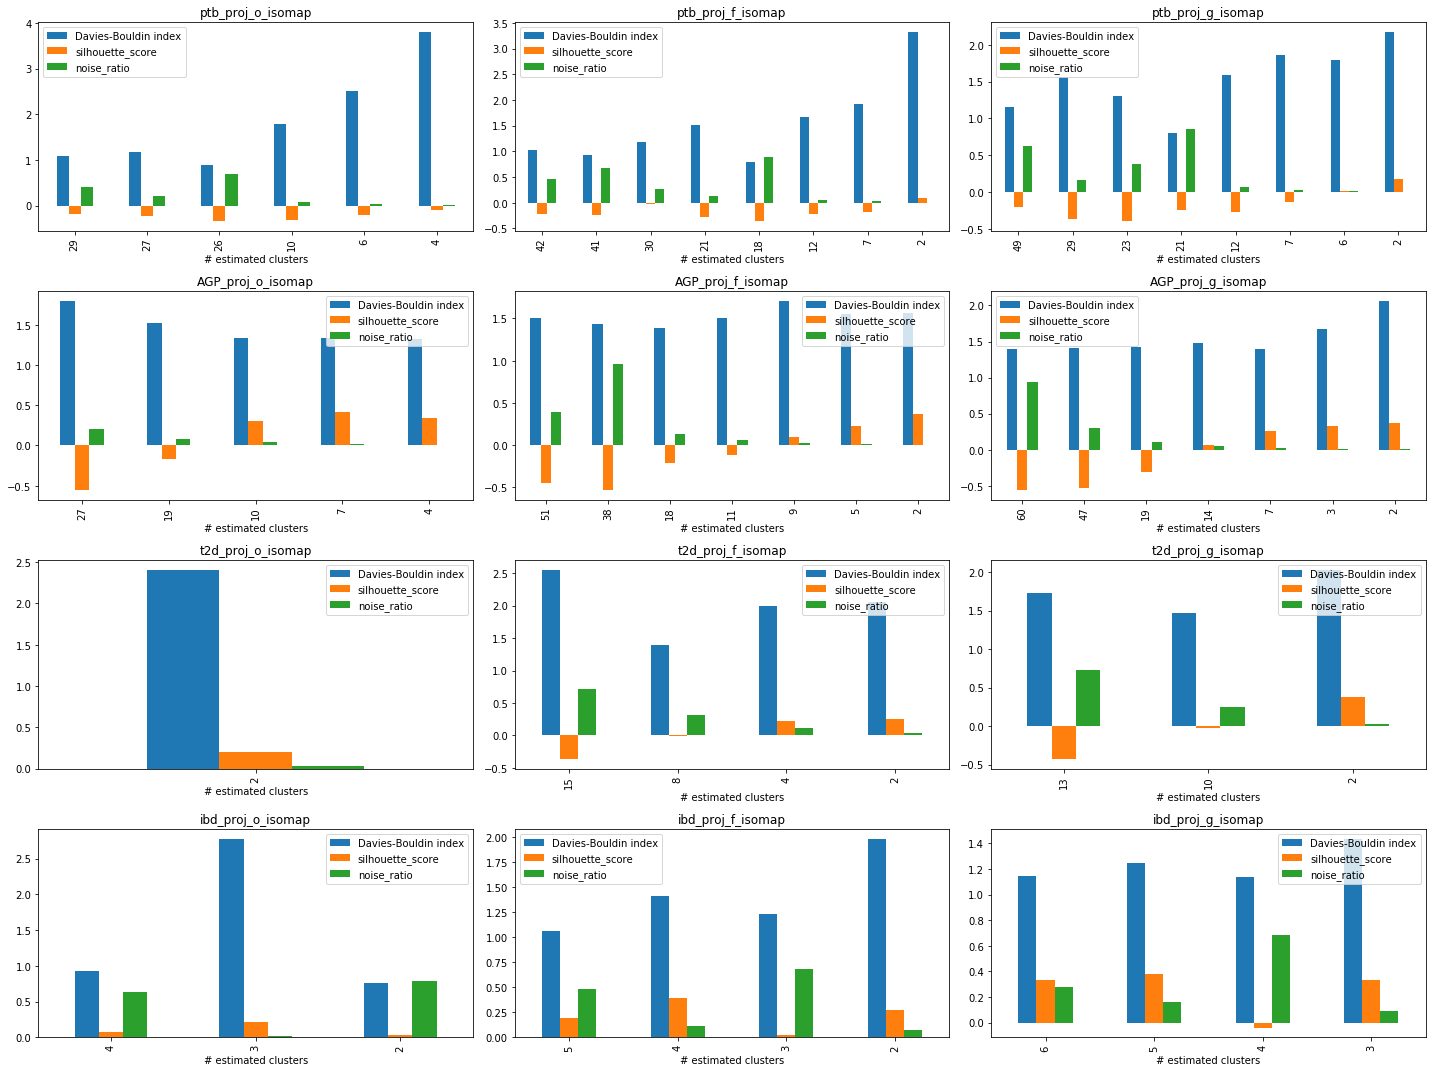

In [26]:
plot_proj_clustering(isomap_cluster_results_list[0], 'isomap')

# KMEANS: ISOMAP

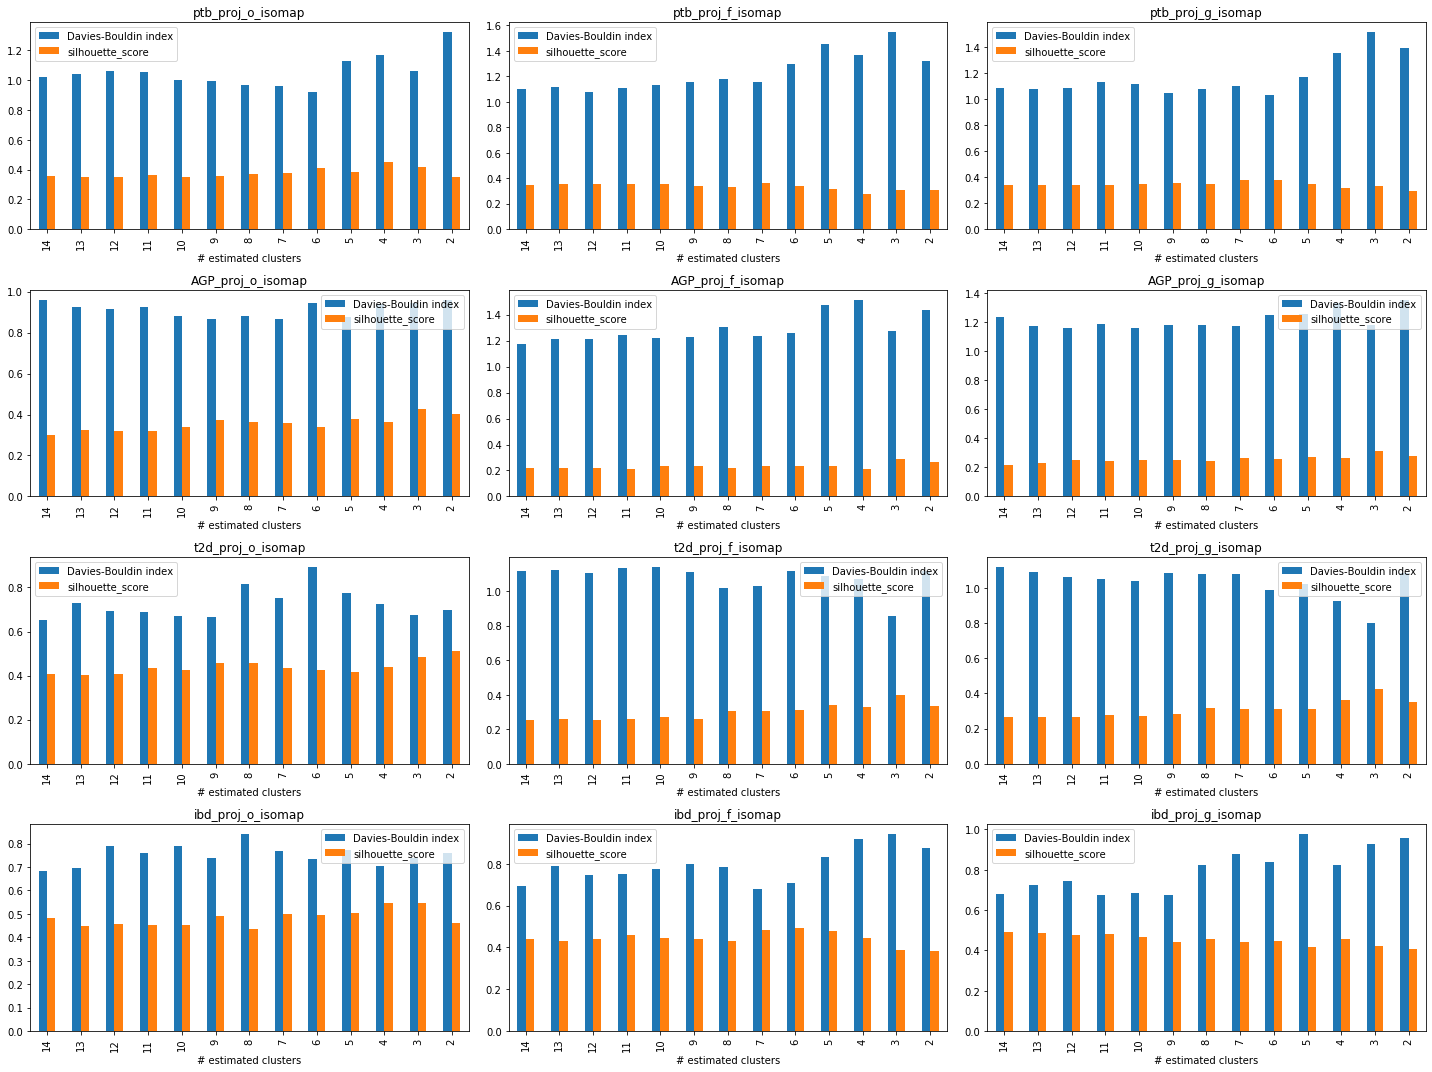

In [27]:
plot_proj_clustering(isomap_cluster_results_list[1], 'isomap')

# SPECTRAL: ISOMAP

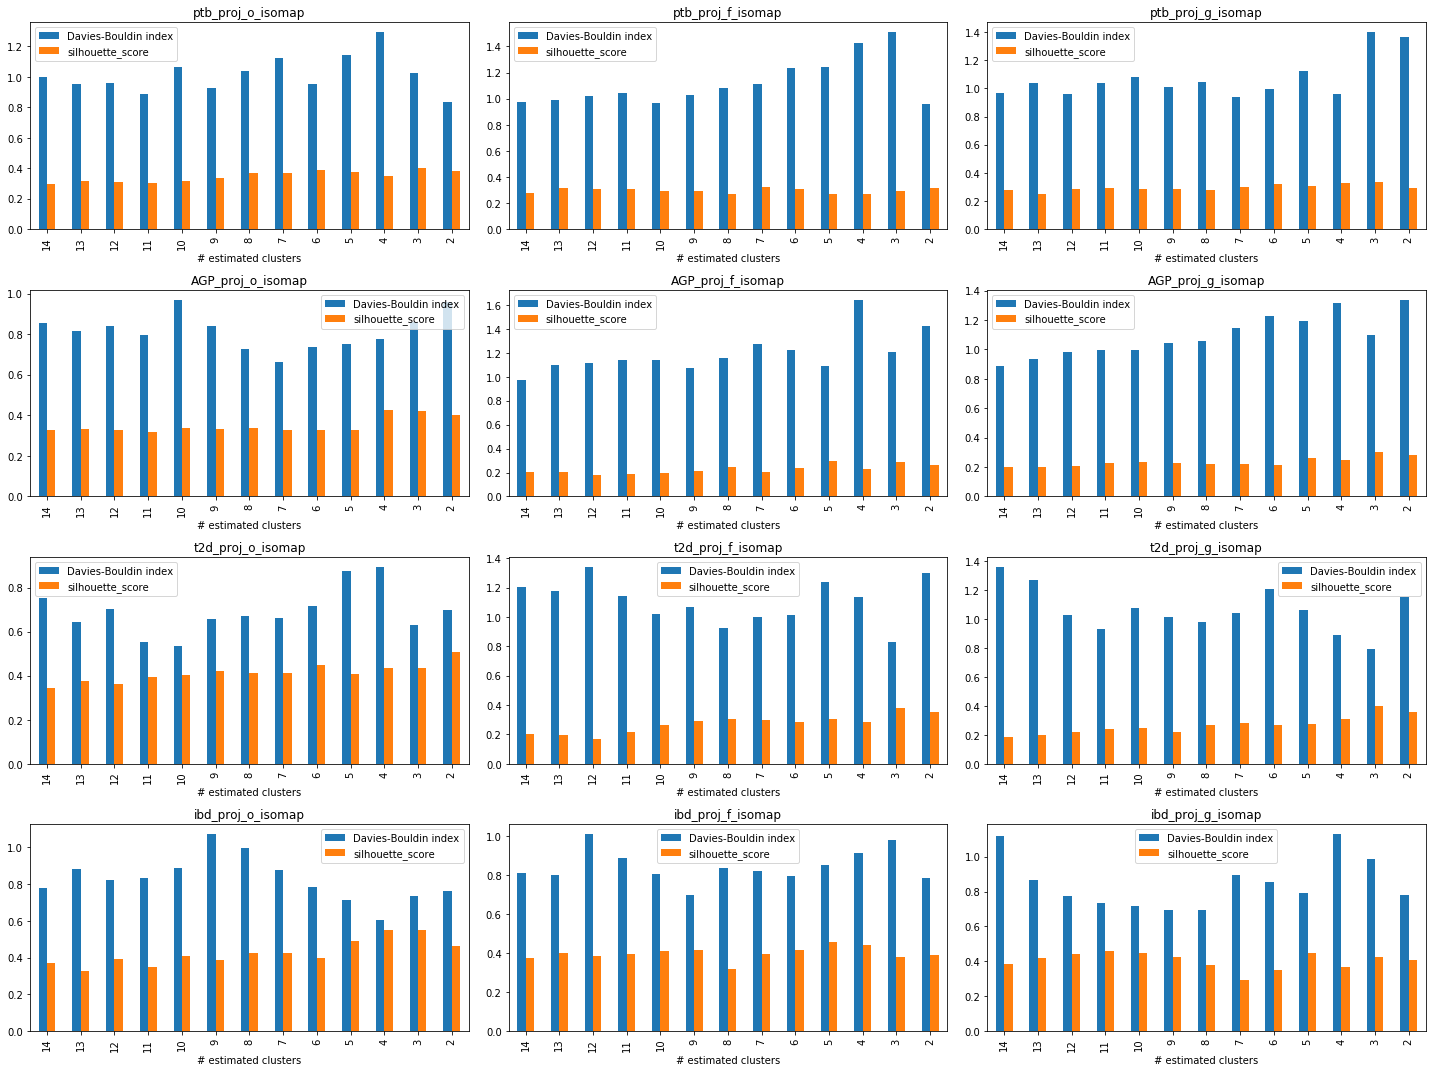

In [28]:
plot_proj_clustering(isomap_cluster_results_list[2], 'isomap')

In [86]:
X_dbind_isomap, X_silh_isomap = create_clustering_pivot_table(copy(isomap_cluster_results_list), methods_names, datasets_names, manifold='isomap', noise_threshold=0.5)

In [87]:
X_dbind_isomap

AGP_proj_f  AGP_proj_g  AGP_proj_o  ibd_proj_f  \
dbscan                    18.0         7.0         4.0         5.0   
KMeans                    14.0        12.0         7.0         7.0   
SpectralClustering        14.0        14.0         7.0         9.0   

                    ibd_proj_g  ibd_proj_o  ptb_proj_f  ptb_proj_g  \
dbscan                     6.0         3.0        42.0        23.0   
KMeans                     9.0        14.0        12.0         6.0   
SpectralClustering         9.0         4.0         2.0         7.0   

                    ptb_proj_o  t2d_proj_f  t2d_proj_g  t2d_proj_o  
dbscan                    29.0         8.0        10.0         2.0  
KMeans                     6.0         3.0         3.0        14.0  
SpectralClustering         2.0         3.0         3.0        10.0

In [88]:
X_silh_isomap

AGP_proj_f  AGP_proj_g  AGP_proj_o  ibd_proj_f  \
dbscan                     2.0         2.0         7.0         4.0   
KMeans                     3.0         3.0         3.0         6.0   
SpectralClustering         5.0         3.0         4.0         5.0   

                    ibd_proj_g  ibd_proj_o  ptb_proj_f  ptb_proj_g  \
dbscan                     5.0         3.0         2.0         2.0   
KMeans                    14.0         3.0         7.0         6.0   
SpectralClustering        11.0         3.0         7.0         3.0   

                    ptb_proj_o  t2d_proj_f  t2d_proj_g  t2d_proj_o  
dbscan                     4.0         2.0         2.0         2.0  
KMeans                     4.0         3.0         3.0         2.0  
SpectralClustering         3.0         3.0         3.0         2.0

# LLE

In [32]:
methods_dict_LLE = {'dbscan':[DBSCAN, np.linspace(0.0001, 0.4, 25)],
                   'KMeans':[KMeans, np.arange(2, 15, 1)],
                   'SpectralClustering':[SpectralClustering, np.arange(2, 15, 1)]}

methods_names = list(methods_dict_LLE.keys())

lle_cluster_results_list = []
for method_name in methods_names:
    method_class, param_range = methods_dict_LLE[method_name]
    cluster_results = clustering(paths_mf_lle, method_class, param_range)
    lle_cluster_results_list.append(cluster_results)

Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.0001
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.0167625
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.033425
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.05008750000000001
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.06675
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.0834125
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.10007500000000001
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.11673750000000001
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.1334
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.1500625
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.16672499999999998
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.18338749999999998
Only one cl

Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.2667
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.2833625
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.300025
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.3166875
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.33335
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.3500125
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.366675
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.3833375
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.4
Only one cluster was found for ptb_proj_o_lle, method: DBSCAN param: 0.033425
Only one cluster was found for ptb_proj_o_lle, method: DBSCAN param: 0.05008750000000001
Only one cluster was found for ptb_proj_o_lle, method: DBSCAN param: 0.06675
Only one cluster was found for ptb_proj_o_lle, method: DBS

Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.16672499999999998
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.18338749999999998
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.20005
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.2167125
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.233375
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.2500375
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.2667
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.2833625
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.300025
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.3166875
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.33335
Only one cluster was found for AGP_proj_g_lle, method: DBSCAN param: 0.3500125
Only one cluster was found for AGP_proj_g

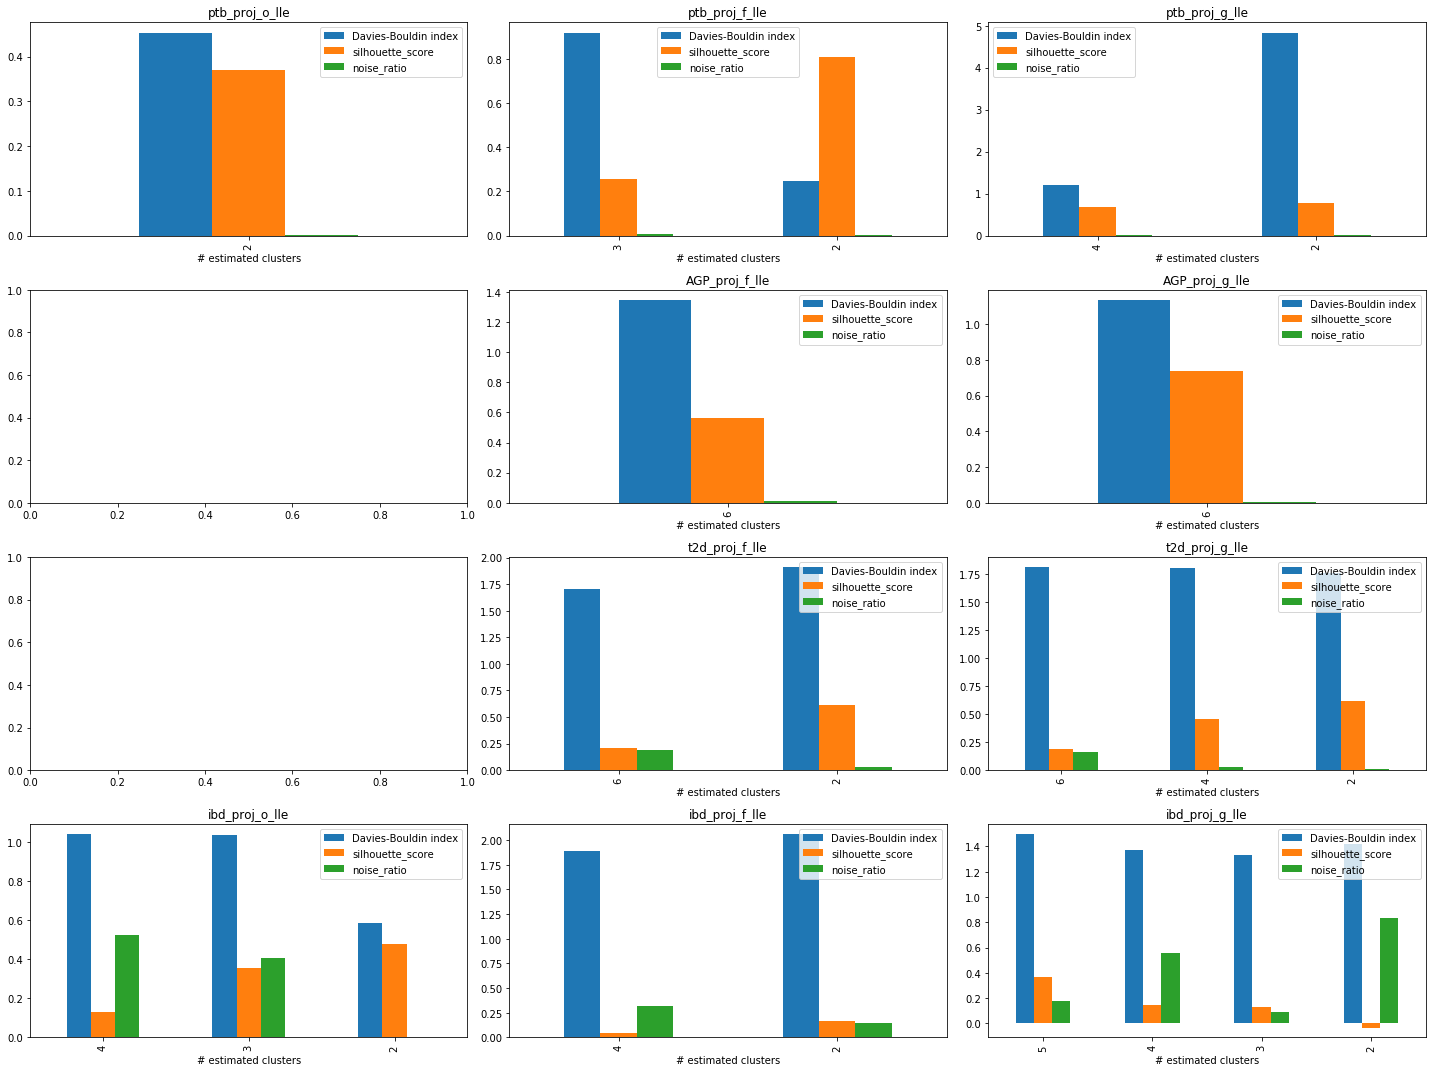

In [33]:
plot_proj_clustering(lle_cluster_results_list[0], 'lle')

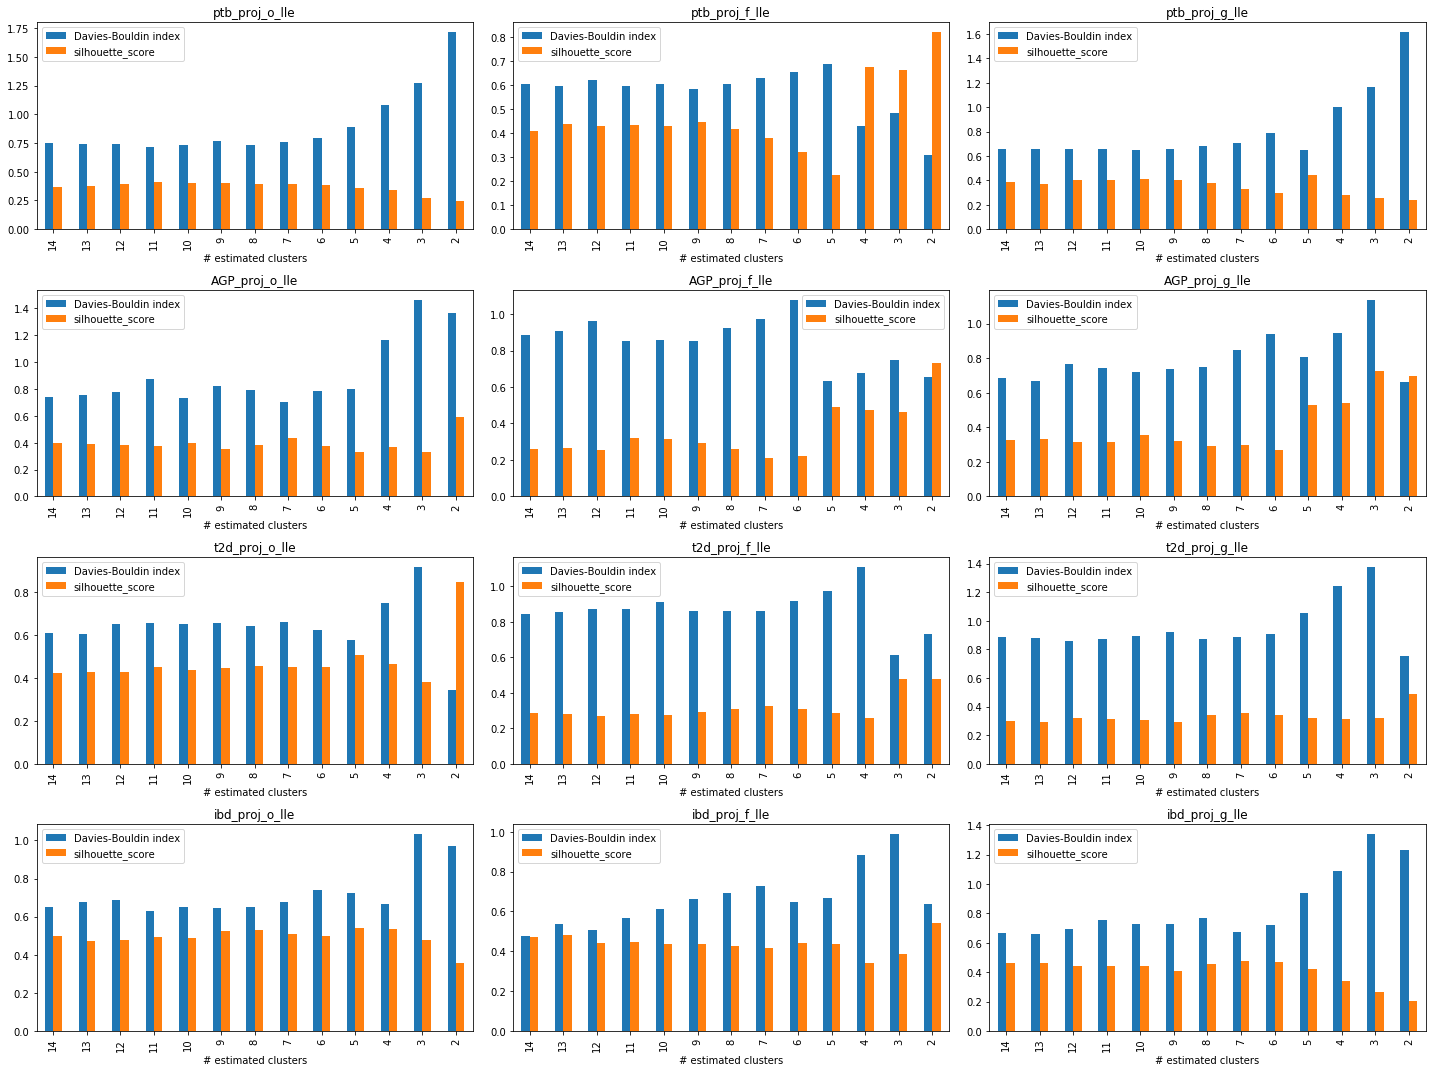

In [34]:
plot_proj_clustering(lle_cluster_results_list[1], 'lle')

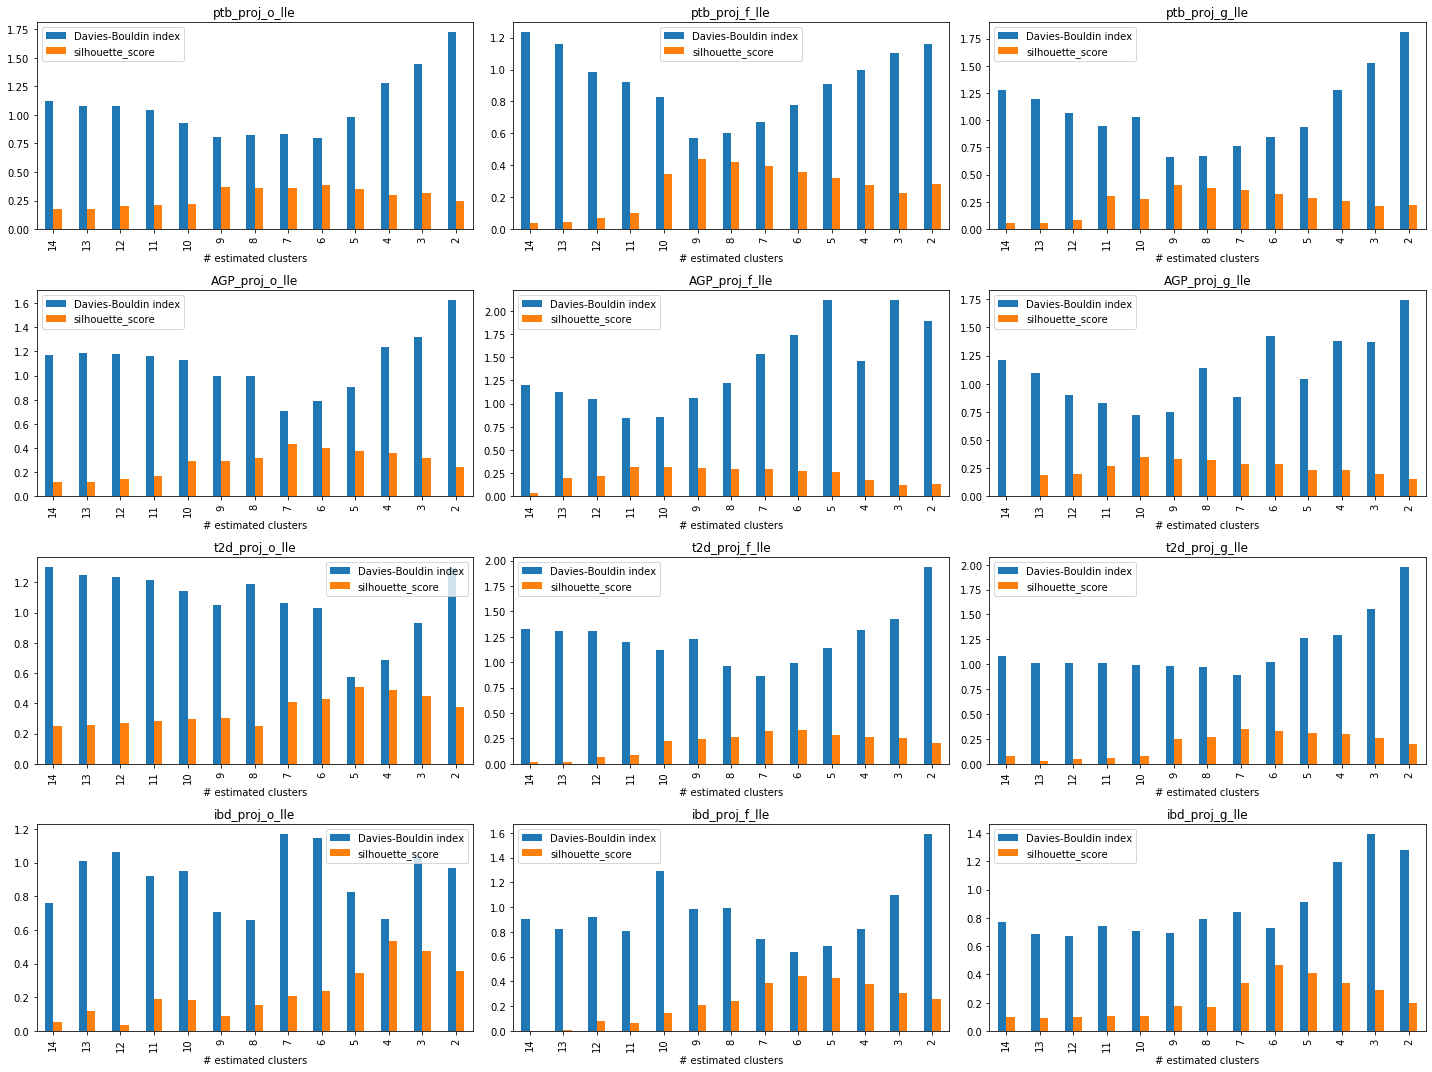

In [101]:
plot_proj_clustering(lle_cluster_results_list[2], 'lle')

In [89]:
X_dbind_lle, X_silh_lle = create_clustering_pivot_table(lle_cluster_results_list, methods_names, datasets_names, manifold='lle')

In [90]:
X_dbind_lle

AGP_proj_f  AGP_proj_g  AGP_proj_o  ibd_proj_f  \
dbscan                     6.0         6.0         1.0         2.0   
KMeans                     5.0         2.0         7.0        14.0   
SpectralClustering        11.0        10.0         7.0         6.0   

                    ibd_proj_g  ibd_proj_o  ptb_proj_f  ptb_proj_g  \
dbscan                     3.0         2.0         2.0         4.0   
KMeans                    13.0        11.0         2.0         5.0   
SpectralClustering        12.0         8.0         9.0         9.0   

                    ptb_proj_o  t2d_proj_f  t2d_proj_g  t2d_proj_o  
dbscan                     2.0         6.0         2.0         1.0  
KMeans                    11.0         3.0         2.0         2.0  
SpectralClustering         6.0         7.0         7.0         5.0

In [91]:
X_silh_lle

AGP_proj_f  AGP_proj_g  AGP_proj_o  ibd_proj_f  \
dbscan                     6.0         6.0         1.0         2.0   
KMeans                     2.0         3.0         2.0         2.0   
SpectralClustering        11.0        10.0         7.0         6.0   

                    ibd_proj_g  ibd_proj_o  ptb_proj_f  ptb_proj_g  \
dbscan                     5.0         2.0         2.0         2.0   
KMeans                     7.0         5.0         2.0         5.0   
SpectralClustering         6.0         4.0         9.0         9.0   

                    ptb_proj_o  t2d_proj_f  t2d_proj_g  t2d_proj_o  
dbscan                     2.0         2.0         2.0         1.0  
KMeans                    11.0         3.0         2.0         2.0  
SpectralClustering         6.0         6.0         7.0         5.0

# Aggregated pivot tables: DBIND

In [92]:
X_dbind_lle.index = [i + '_lle' for i in X_dbind_lle.index]
X_dbind_isomap.index = [i + '_isomap' for i in X_dbind_isomap.index]

In [93]:
X_dbind_all = pd.concat([X_dbind, X_dbind_lle, X_dbind_isomap], axis = 0)
X_dbind_all

AGP_proj_f  AGP_proj_g  AGP_proj_o  ibd_proj_f  \
dbscan                           12.0        13.0        11.0         5.0   
KMeans                            2.0         3.0         2.0        14.0   
SpectralClustering               13.0        12.0        12.0        10.0   
dbscan_lle                        6.0         6.0         1.0         2.0   
KMeans_lle                        5.0         2.0         7.0        14.0   
SpectralClustering_lle           11.0        10.0         7.0         6.0   
dbscan_isomap                    18.0         7.0         4.0         5.0   
KMeans_isomap                    14.0        12.0         7.0         7.0   
SpectralClustering_isomap        14.0        14.0         7.0         9.0   

                           ibd_proj_g  ibd_proj_o  ptb_proj_f  ptb_proj_g  \
dbscan                            6.0         3.0        19.0        11.0   
KMeans                           13.0        14.0         2.0         2.0   
SpectralClustering               10.0         6.0         2.0         7.0   
dbscan_lle                        3.0         2.0         2.0         4.0   
KMeans_lle                       13.0        11.0         2.0         5.0   
SpectralClustering_lle           12.0         8.0         9.0         9.0   
dbscan_isomap                     6.0         3.0        42.0        23.0   
KMeans_isomap                     9.0        14.0        12.0         6.0   
SpectralClustering_isomap         9.0         4.0         2.0         7.0   

                           ptb_proj_o  t2d_proj_f  t2d_proj_g  t2d_proj_o  
dbscan                           13.0         4.0         6.0         5.0  
KMeans                            2.0         3.0         3.0        13.0  
SpectralClustering                2.0         3.0         3.0         3.0  
dbscan_lle                        2.0         6.0         2.0         1.0  
KMeans_lle                       11.0         3.0         2.0         2.0  
SpectralClustering_lle            6.0         7.0         7.0         5.0  
dbscan_isomap                    29.0         8.0        10.0         2.0  
KMeans_isomap                     6.0         3.0         3.0        14.0  
SpectralClustering_isomap         2.0         3.0         3.0        10.0

# Aggregated pivot tables: SILHOETTE

In [94]:
X_silh_lle.index = [i + '_lle' for i in X_silh_lle.index]
X_silh_isomap.index = [i + '_isomap' for i in X_silh_isomap.index]
X_silh_all = pd.concat([X_silh, X_silh_lle, X_silh_isomap], axis = 0)
X_silh_all

AGP_proj_f  AGP_proj_g  AGP_proj_o  ibd_proj_f  \
dbscan                            2.0         2.0         2.0         4.0   
KMeans                            4.0         3.0         3.0         7.0   
SpectralClustering                3.0         3.0         5.0         7.0   
dbscan_lle                        6.0         6.0         1.0         2.0   
KMeans_lle                        2.0         3.0         2.0         2.0   
SpectralClustering_lle           11.0        10.0         7.0         6.0   
dbscan_isomap                     2.0         2.0         7.0         4.0   
KMeans_isomap                     3.0         3.0         3.0         6.0   
SpectralClustering_isomap         5.0         3.0         4.0         5.0   

                           ibd_proj_g  ibd_proj_o  ptb_proj_f  ptb_proj_g  \
dbscan                            6.0         3.0         3.0         2.0   
KMeans                           14.0         4.0        11.0         7.0   
SpectralClustering                5.0         3.0         2.0         3.0   
dbscan_lle                        5.0         2.0         2.0         2.0   
KMeans_lle                        7.0         5.0         2.0         5.0   
SpectralClustering_lle            6.0         4.0         9.0         9.0   
dbscan_isomap                     5.0         3.0         2.0         2.0   
KMeans_isomap                    14.0         3.0         7.0         6.0   
SpectralClustering_isomap        11.0         3.0         7.0         3.0   

                           ptb_proj_o  t2d_proj_f  t2d_proj_g  t2d_proj_o  
dbscan                            2.0         4.0         2.0         3.0  
KMeans                            9.0         3.0         3.0         2.0  
SpectralClustering                2.0         3.0         3.0         2.0  
dbscan_lle                        2.0         2.0         2.0         1.0  
KMeans_lle                       11.0         3.0         2.0         2.0  
SpectralClustering_lle            6.0         6.0         7.0         5.0  
dbscan_isomap                     4.0         2.0         2.0         2.0  
KMeans_isomap                     4.0         3.0         3.0         2.0  
SpectralClustering_isomap         3.0         3.0         3.0         2.0

# Visualisation 2D PCA

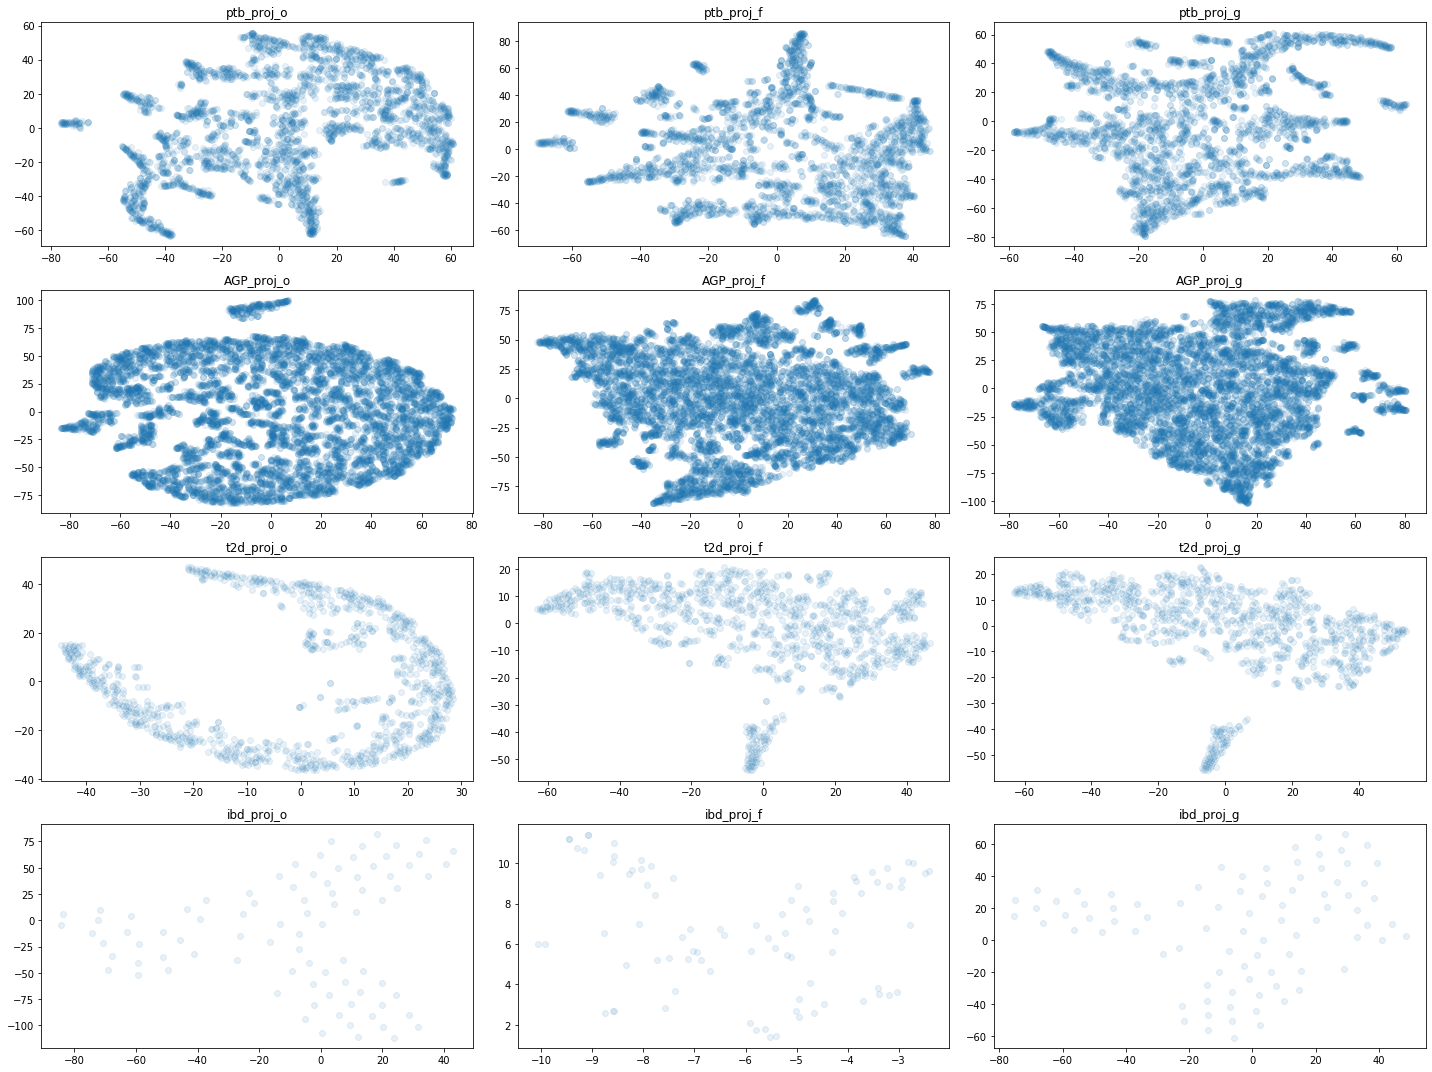

In [96]:
tsne2d_pca = {}
from sklearn.manifold import TSNE
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name])
        path = label2path[label]
        dataset = np.genfromtxt(path, delimiter=';')
        tsne2 = TSNE(2)
        tsne2.fit(dataset)
        tsne2d_pca[label] = tsne2.embedding_
        axes[i,j].scatter(tsne2.embedding_[:,0], tsne2.embedding_[:,1], alpha=0.1)
        axes[i,j].set_title(label)
plt.tight_layout()
plt.show()

# Visualisation 2D ISOMAP

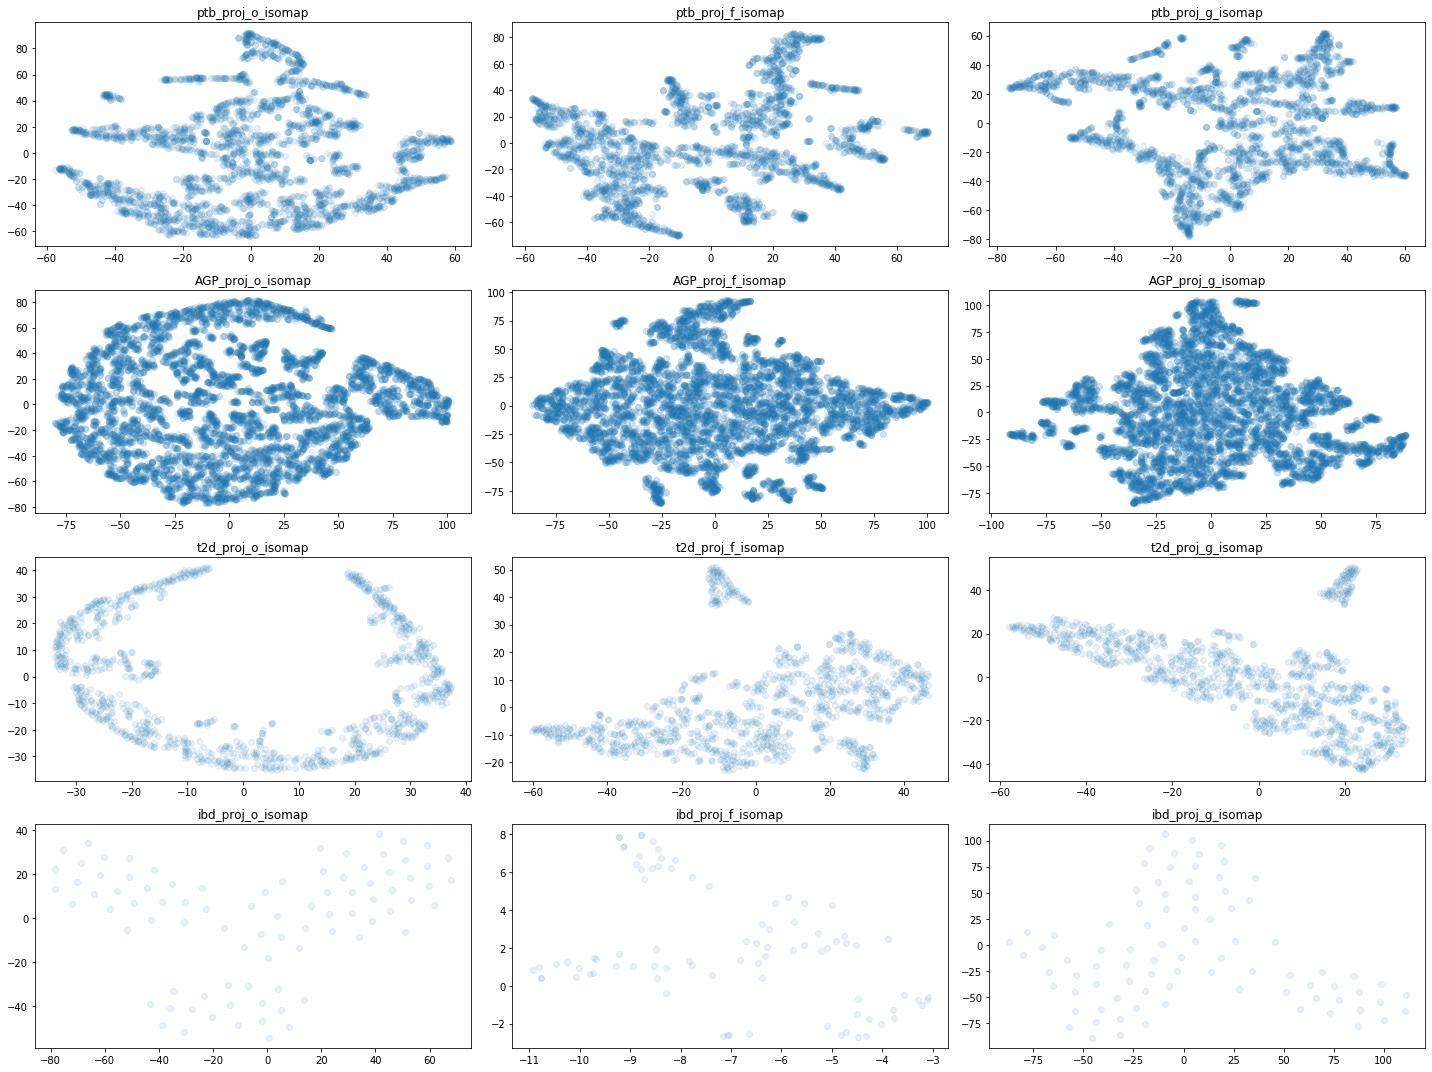

In [97]:
tsne2d_isomap = {}
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name, 'isomap'])
        path = label2path[label]
        dataset = np.genfromtxt(path, delimiter=';')
        tsne2 = TSNE(2)
        tsne2.fit(dataset)
        tsne2d_isomap[label] = tsne2.embedding_
        axes[i,j].scatter(tsne2.embedding_[:,0], tsne2.embedding_[:,1], alpha=0.1)
        axes[i,j].set_title(label)
plt.tight_layout()
plt.show()

# Visualisation 2D LLE

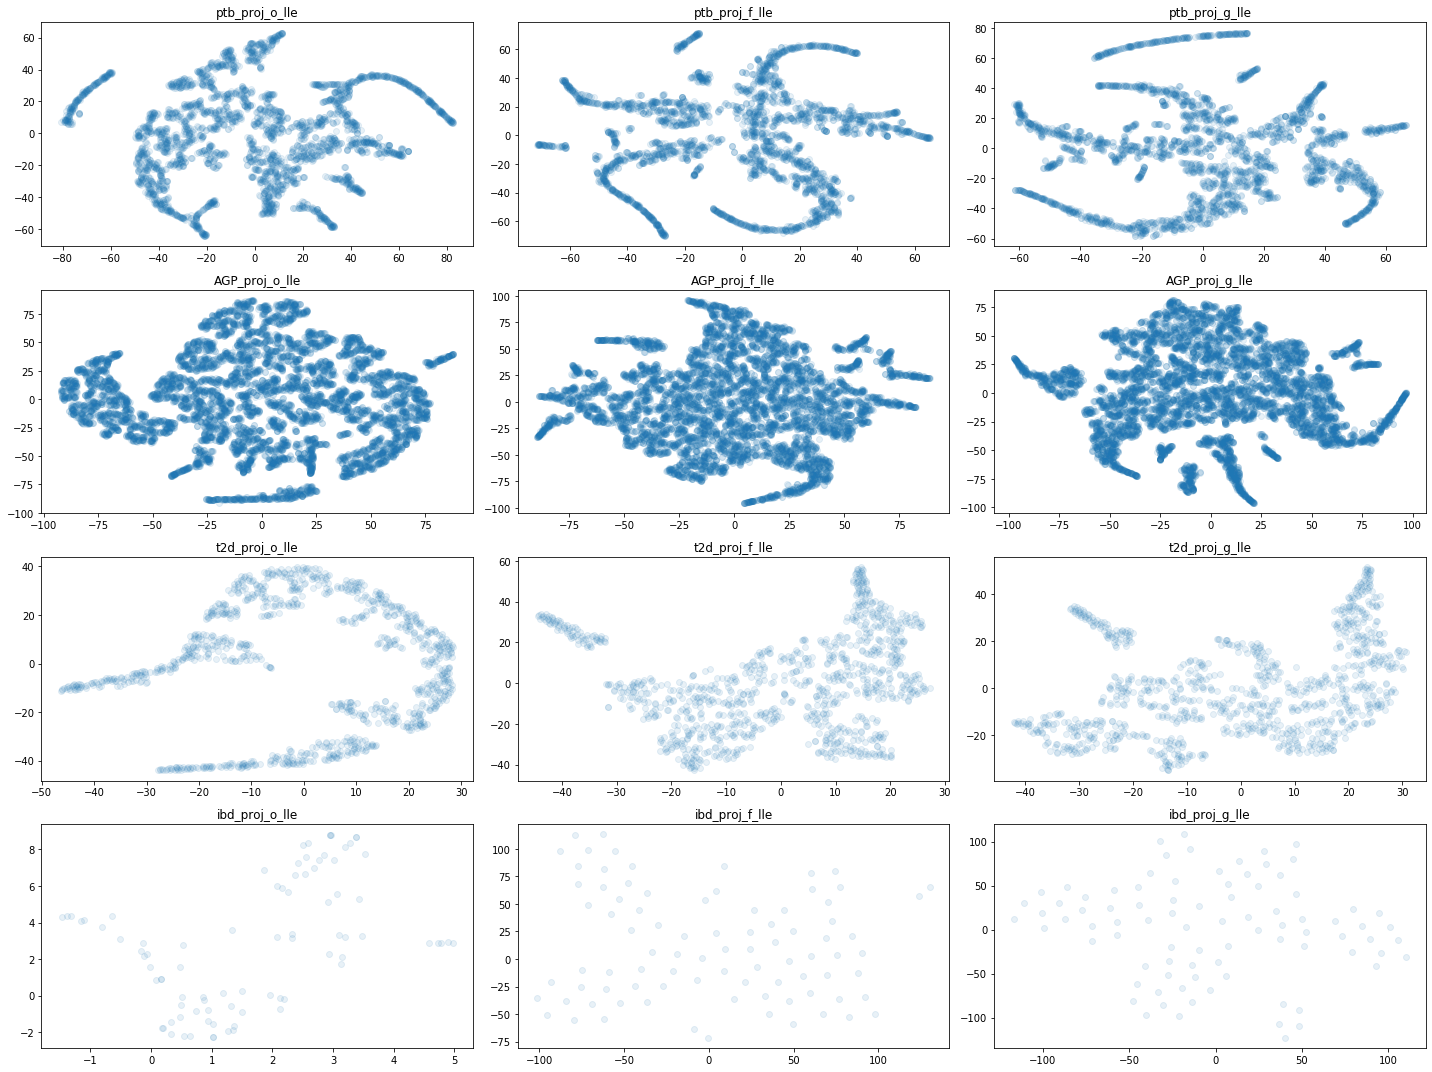

In [98]:
tsne2d_lle = {}
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name, 'lle'])
        path = label2path[label]
        dataset = np.genfromtxt(path, delimiter=';')
        tsne2 = TSNE(2)
        tsne2.fit(dataset)
        tsne2d_lle[label] = tsne2.embedding_
        axes[i,j].scatter(tsne2.embedding_[:,0], tsne2.embedding_[:,1], alpha=0.1)
        axes[i,j].set_title(label)
plt.tight_layout()
plt.show()

# TSNE3D PCA

In [109]:
from mpl_toolkits.mplot3d import Axes3D 

In [110]:
# tsne3d_results = {}
# n_datasets = 4
# n_taxes = 3
# # fig = plt.figure(figsize=(25,20))
# for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
#     for j,tax_name in enumerate(['o', 'f', 'g']):
# #         ax = fig.add_subplot(n_datasets, n_taxes, i+j+1, projection='3d')
#         label = '_'.join([dataset_name, 'proj', tax_name])
#         path = label2path[label]
#         dataset = np.genfromtxt(path, delimiter=';')
#         tsne3 = TSNE(3)
#         tsne3.fit(dataset)
#         tsne3d_results[label] = tsne3.embedding_
# #         ax.scatter(tsne3.embedding_[:,0], tsne3.embedding_[:,1], tsne3.embedding_[:,2], marker='.', alpha=0.7)
# #         ax.set_title(label, fontsize=20)
# # plt.tight_layout()
# # plt.show()

In [ ]:
TSNE()

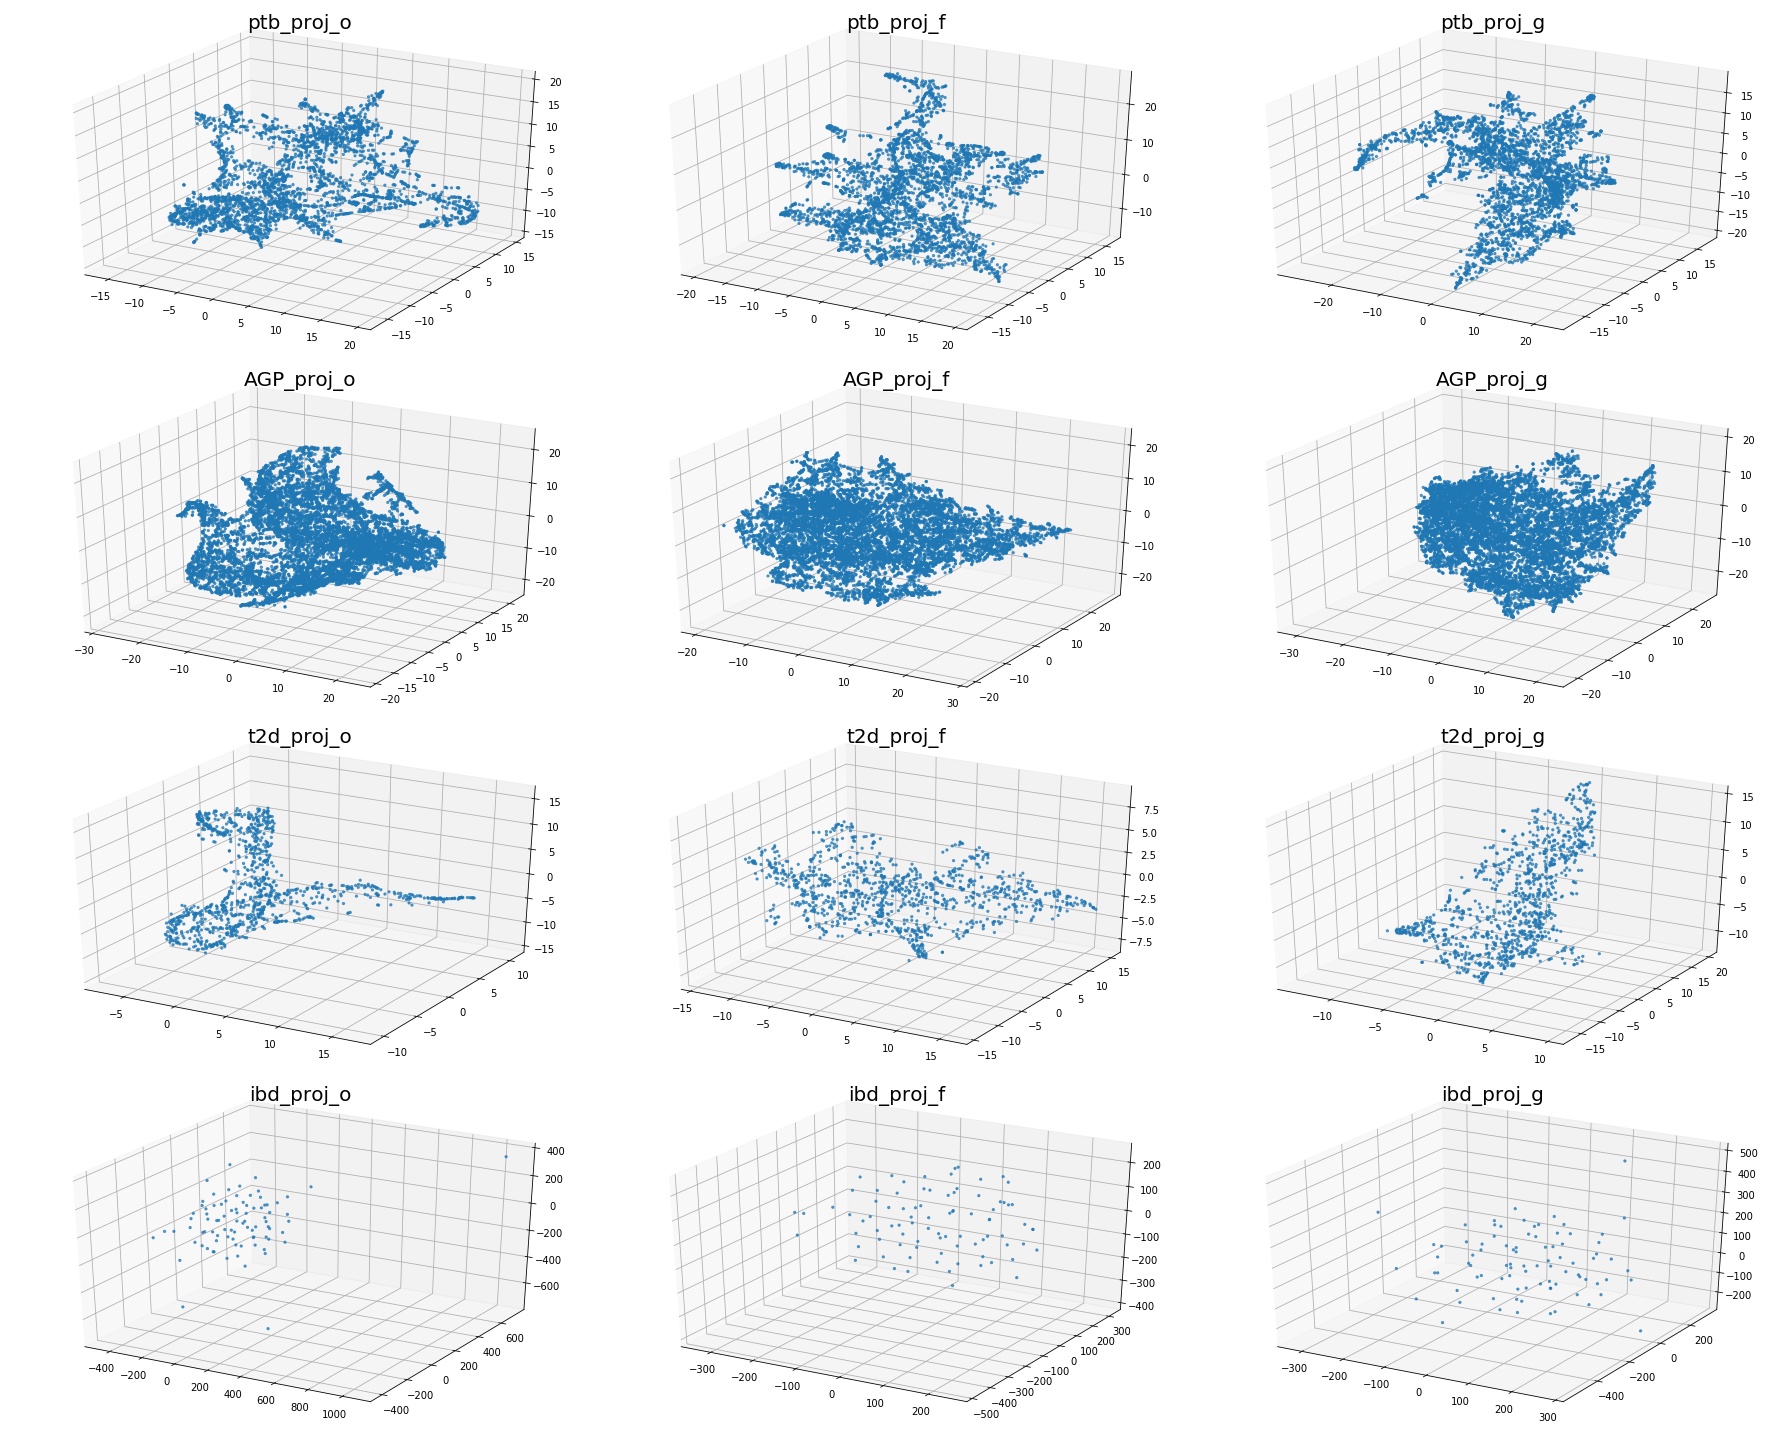

In [113]:
fig = plt.figure(figsize=(25,20))
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name])
        embedding_ = tsne3d_results[label]
        
        ax = fig.add_subplot(4, 3, i*3+j+1, projection='3d')
        ax.scatter(embedding_[:,0], embedding_[:,1], embedding_[:,2], marker='.', alpha=0.7)
        ax.set_title(label, fontsize=20)
plt.tight_layout()
plt.show()

# TSNE3D ISOMAP

In [ ]:
tsne3d_results_isomap = {}
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name, 'isomap'])
        path = label2path[label]
        dataset = np.genfromtxt(path, delimiter=';')
        tsne3 = TSNE(3)
        tsne3.fit(dataset) 
        tsne3d_results_isomap[label] = tsne3.embedding_

# TSNE3D LLE

In [ ]:
tsne3d_results_lle = {}
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name, 'lle'])
        path = label2path[label]
        dataset = np.genfromtxt(path, delimiter=';')
        tsne3 = TSNE(3)
        tsne3.fit(dataset) 
        tsne3d_results_lle[label] = tsne3.embedding_